In [1]:
from collections import OrderedDict

import numpy as np
from scipy.stats import multivariate_normal

import pickle

import matplotlib.pyplot as plt

import gen_metrics
import dists

from math import ceil, sqrt

import pandas as pd

from IPython.display import Markdown, display
import plotting

from tqdm import tqdm

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

plot_dir = "../plots/toy_plots/Jan25"
_ = os.system(f"mkdir -p {plot_dir}")


In [4]:
metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {}, "Wasserstein")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        ("fgd_inf", (gen_metrics.frechet_gaussian_distance, {}, r"$\mathrm{FGD}_\infty$")),
        # ("mmdub", (gen_metrics.mmd_gaussian_quadratic_biased, {}, "MMD Quadratic Biased Est.")),
        ("mmdu", (gen_metrics.mmd_gaussian_quadratic_unbiased, {}, "MMD Gaussian")),
        # ("mmdl", (gen_metrics.mmd_gaussian_linear, {}, "MMD Linear Estimator")),
        (
            "mmdup",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 3},
                "MMD Poly Deg=3",
            ),
        ),
        # ("mmdlp", (gen_metrics.mmd_poly_linear, {"degree": 3}, "MMD Poly Deg=3 Linear Estimator")),
        (
            "mmdup4",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 4},
                "MMD Poly Deg=4",
            ),
        ),
        # ("mmdlp4", (gen_metrics.mmd_poly_linear, {"degree": 4}, "MMD Poly Deg=4 Linear Estimator")),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
        ("dc", (gen_metrics.dc, {}, ["Density", "Coverage"])),
    ]
)


In [5]:
true_var = 1.0
true_cov = 0.25
var_factor = 10
mixture_means1 = 0.6
mixture_means2 = 0.75

test_dists = [
    (
        # rf"Truth N(0.0 $\mu$, 1.0 $\sigma^2$, 0.25 cov)",
        rf"Truth",
        multivariate_normal([0, 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"Shift $\mu_x$ by 1 $\sigma$",
        multivariate_normal([sqrt(true_var), 0], [[true_var, true_cov], [true_cov, true_var]]),
    ),
    (
        rf"Shift $\mu_x$ by 0.1 $\sigma$",
        multivariate_normal(
            [sqrt(true_var) / 10.0, 0], [[true_var, true_cov], [true_cov, true_var]]
        ),
    ),
    (
        rf"Zero covariance",
        multivariate_normal([0, 0], [[true_var, 0], [0, true_var]]),
    ),
    (
        rf"Multiply (co)variances by 10",
        multivariate_normal(
            [0, 0],
            [
                [true_var * var_factor, true_cov * var_factor],
                [true_cov * var_factor, true_var * var_factor],
            ],
        ),
    ),
    (
        rf"Divide (co)variances by 10",
        multivariate_normal(
            [0, 0],
            [
                [true_var / var_factor, true_cov / var_factor],
                [true_cov / var_factor, true_var / var_factor],
            ],
        ),
    ),
    (
        r"Mixture of Two Gaussians 1",
        dists.two_multivariate_normals(
            mixture_means1, true_var - mixture_means1**2, true_cov - mixture_means1**2
        ),
    ),
    (
        r"Mixture of Two Gaussians 2",
        dists.two_multivariate_normals(
            mixture_means2, true_var - mixture_means2**2, true_cov - mixture_means2**2
        ),
    ),
]

# kernel_var = gen_metrics.get_kernel_var(true_samples)
# metrics["mmdub"][1]["kernel_sigma"] = sqrt(true_var)
metrics["mmdu"][1]["kernel_sigma"] = sqrt(true_var)
# metrics["mmdl"][1]["kernel_sigma"] = sqrt(true_var)


# Plot distributions

In [6]:
bound = 3
x, y = np.mgrid[-bound:bound:0.01, -bound:bound:0.01]
pos = np.dstack((x, y))


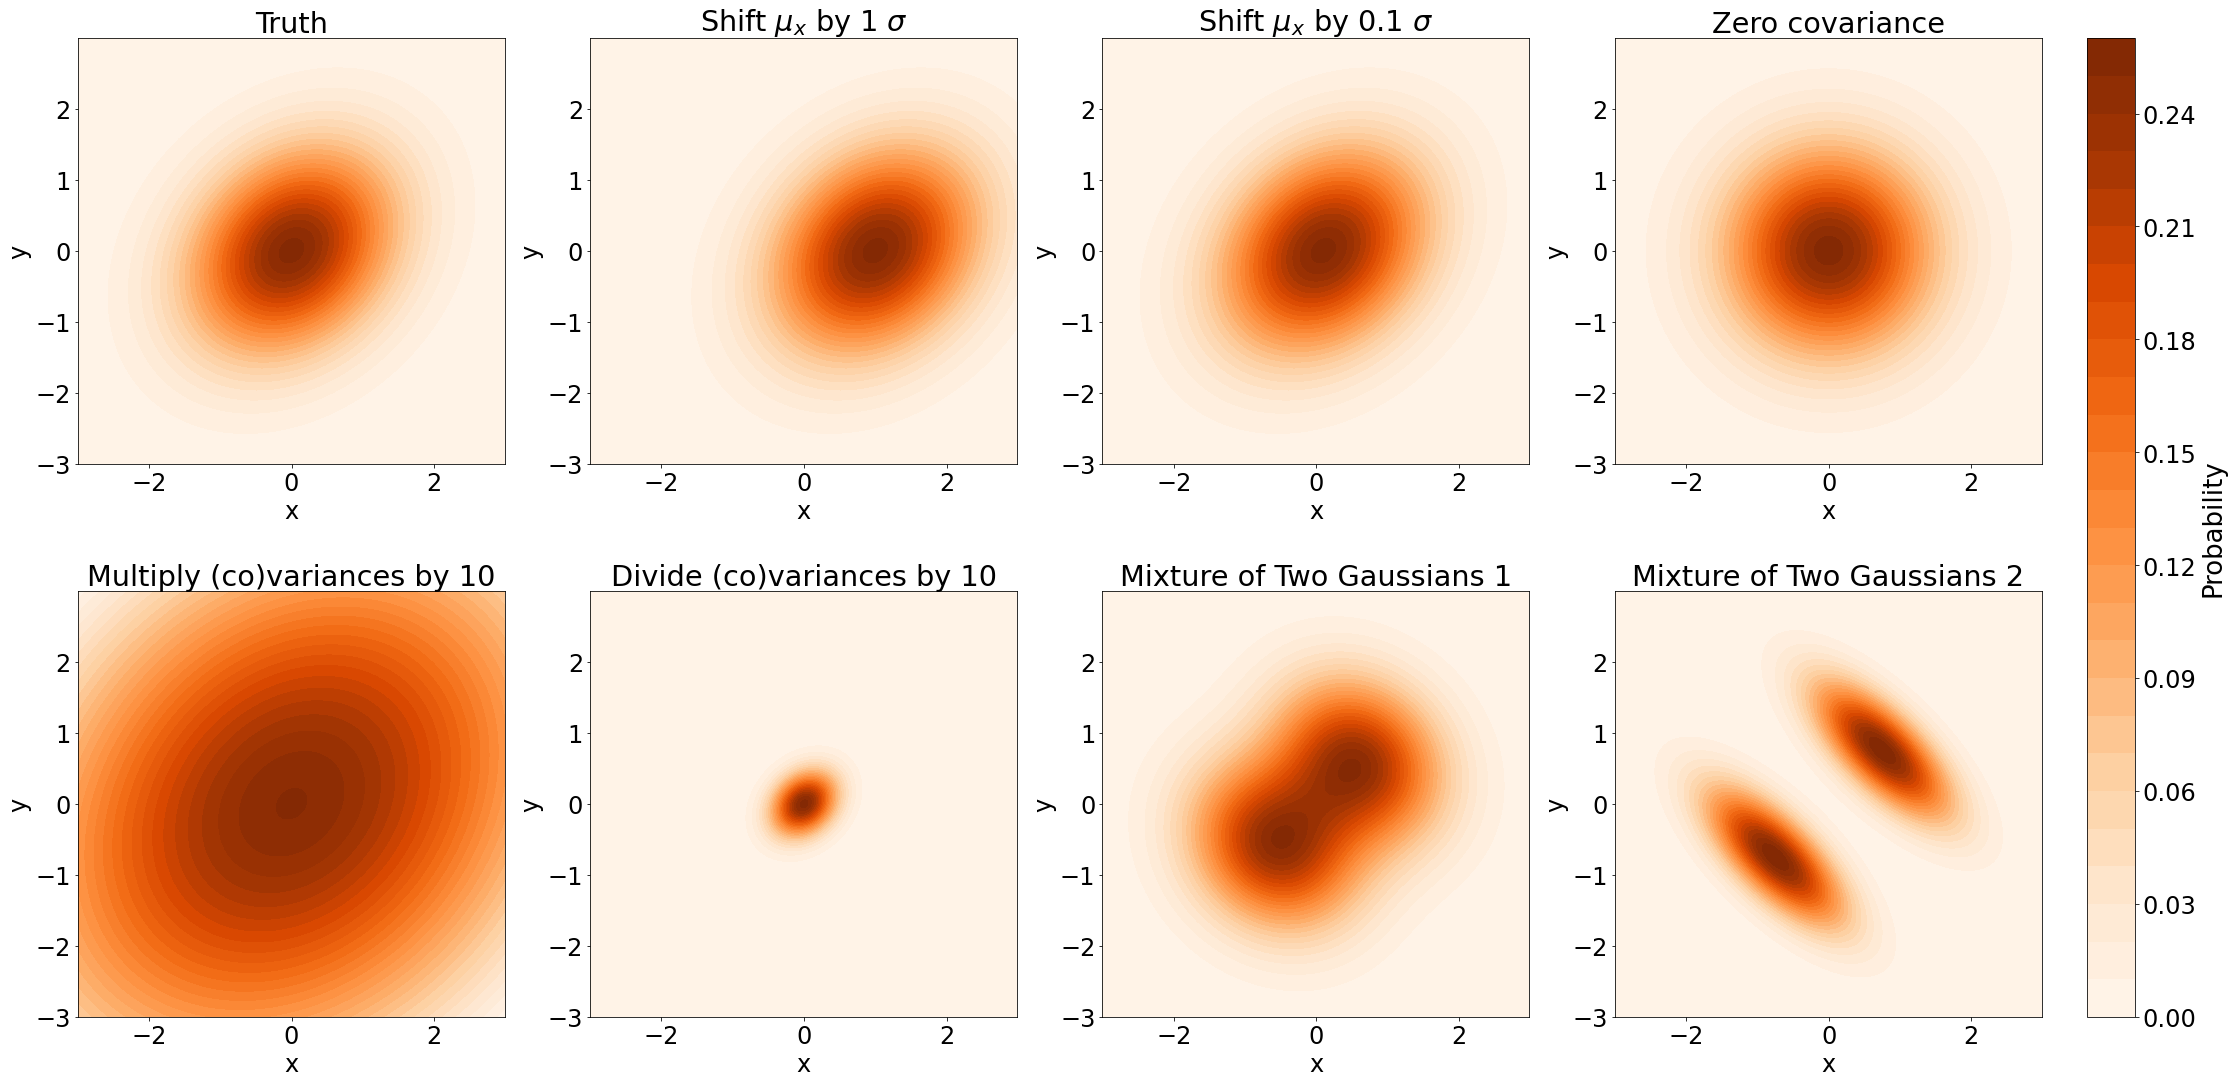

In [8]:
cm = plt.cm.Oranges
plt.rcParams.update({"font.size": 24})

nrows = 2
ncols = int(ceil(len(test_dists) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 9),
    gridspec_kw={"wspace": 0.2, "hspace": 0.3},
)


for i, (label, dist) in enumerate(test_dists):
    row = i // ncols
    col = i % ncols
    cf = axes[row][col].contourf(x, y, dist.pdf(pos), 30, cmap=cm)
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("x")
    axes[row][col].set_ylabel("y")

cbar = fig.colorbar(cf, ax=axes.ravel().tolist(), fraction=0.1, pad=0.02)
cbar.set_label("Probability", size=26)

plt.savefig(f"{plot_dir}/test_dists.pdf", bbox_inches="tight")


# Measurements

In [13]:
num_batches = 5
tot_num_samples = 50_000

batch_sizes = {
    "wasserstein": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        2500,
        3000,
        4000,
        5000,
        7000,
        10_000,
    ],
    "fgd": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000, 7500, 10000, 15000],
    "fgd_inf": [25_000, 30_000, 35_000, 40_000, 45_000, 50_000],
    "mmdub": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000],
    "mmdu": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "mmdl": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        30000,
    ],
    "mmdup": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "mmdlp": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        30000,
        40000,
        50000,
    ],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "mmdlp4": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        30000,
        40000,
        50000,
    ],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
    "dc": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 5000],
}


In [10]:
samples = OrderedDict()

true_samples = test_dists[0][1].rvs(tot_num_samples)

for key, dist in test_dists:
    samples[key] = dist.rvs(tot_num_samples)


In [11]:
metrics["pr"][1]["X_nearest_neighbour_distances"] = {}
metrics["dc"][1]["X_nearest_neighbour_distances"] = {}

# Can save the true sample nearest neighbours
for batch_size in batch_sizes["pr"]:
    xnnd = gen_metrics.compute_nearest_neighbour_distances(true_samples[:batch_size])
    metrics["pr"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd
    metrics["dc"][1]["X_nearest_neighbour_distances"][batch_size] = xnnd


In [21]:
with open(f"../plots/toy_plots/Nov11/measurements.pkl", "rb") as f:
    measurements = pickle.load(f)


In [20]:
measurements


OrderedDict([('Truth N(0.0 $\\mu$, 1.0 $\\sigma^2$, 0.25 cov)',
              OrderedDict([('wasserstein',
                            {'mean_std': array([[0.21711093, 0.07167105],
                                    [0.13342253, 0.01563894],
                                    [0.09360289, 0.01804137],
                                    [0.07130965, 0.01006404],
                                    [0.05263634, 0.01153542],
                                    [0.04214176, 0.00568991],
                                    [0.02717249, 0.00251705],
                                    [0.02336789, 0.00397411],
                                    [0.02106185, 0.00367152],
                                    [0.01760424, 0.00233056],
                                    [0.01449851, 0.00243996],
                                    [0.01140945, 0.00141265],
                                    [0.01377657, 0.00239686],
                                    [0.01578914, 0.00395958]]),
           

In [36]:
if "measurements" not in locals():
    measurements = OrderedDict()

for dkey, dist in test_dists:
    print(dkey)
    if dkey not in measurements:
        measurements[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if (mkey in measurements[dkey] or mkey == "fgd_inf") and not mkey.startswith("mmdup"):
            continue

        print(mkey)
        ms = []
        ts = []

        # ms = list(measurements[dkey][mkey]["mean_std"])
        # ts = list(measurements[dkey][mkey]["timing"])

        for batch_size in tqdm(batch_sizes[mkey][len(ms) :]):
            if not mkey.startswith("mmdup"):
                mean_std, timing = gen_metrics.multi_batch_evaluation(
                    true_samples,
                    samples[dkey],
                    num_batches,
                    batch_size,
                    metric,
                    normalise=False,
                    timing=True,
                    **metric_args,
                )
                ms.append(mean_std)
                ts.append(timing)
            else:
                mean_std, timing = gen_metrics.multi_batch_evaluation_mmd(
                    true_samples,
                    samples[dkey],
                    num_batches,
                    batch_size,
                    normalise=False,
                    degree=metric_args["degree"],
                    timing=True,
                )
                ms.append(mean_std)
                ts.append(timing)

        # measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}
        measurements[dkey][mkey]["timing"] = np.array(ts)


Truth
mmdup


100%|██████████| 10/10 [00:11<00:00,  1.11s/it]


mmdup4


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


Shift $\mu_x$ by 1 $\sigma$
mmdup


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


mmdup4


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


Shift $\mu_x$ by 0.1 $\sigma$
mmdup


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


mmdup4


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Zero covariance
mmdup


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


mmdup4


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Multiply (co)variances by 10
mmdup


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


mmdup4


100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


Divide (co)variances by 10
mmdup


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


mmdup4


100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


Mixture of Two Gaussians 1
mmdup


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]


mmdup4


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


Mixture of Two Gaussians 2
mmdup


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


mmdup4


100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


### FGD Infinity

In [37]:
mkey = "fgd_inf"

for dkey, dist in test_dists:
    ms = []
    ts = []
    for n in tqdm(batch_sizes[mkey], desc=dkey):
        mean_std, timing = gen_metrics.one_over_n_extrapolation_repeated_measurements(
            true_samples, samples[dkey], normalise=False, max_samples=n, timing=True
        )
        ms.append(mean_std)
        ts.append(timing)

    measurements[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


Mixture of Two Gaussians 2: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]


In [38]:
with open(f"{plot_dir}/measurements.pkl", "wb") as f:
    pickle.dump(measurements, f)


In [22]:
# measurements_old = measurements

# measurements = OrderedDict()

# for i in range(len(test_dists)):
#     measurements[test_dists[i][0]] = measurements_old[list(measurements_old.keys())[i]]


# Plot Metrics

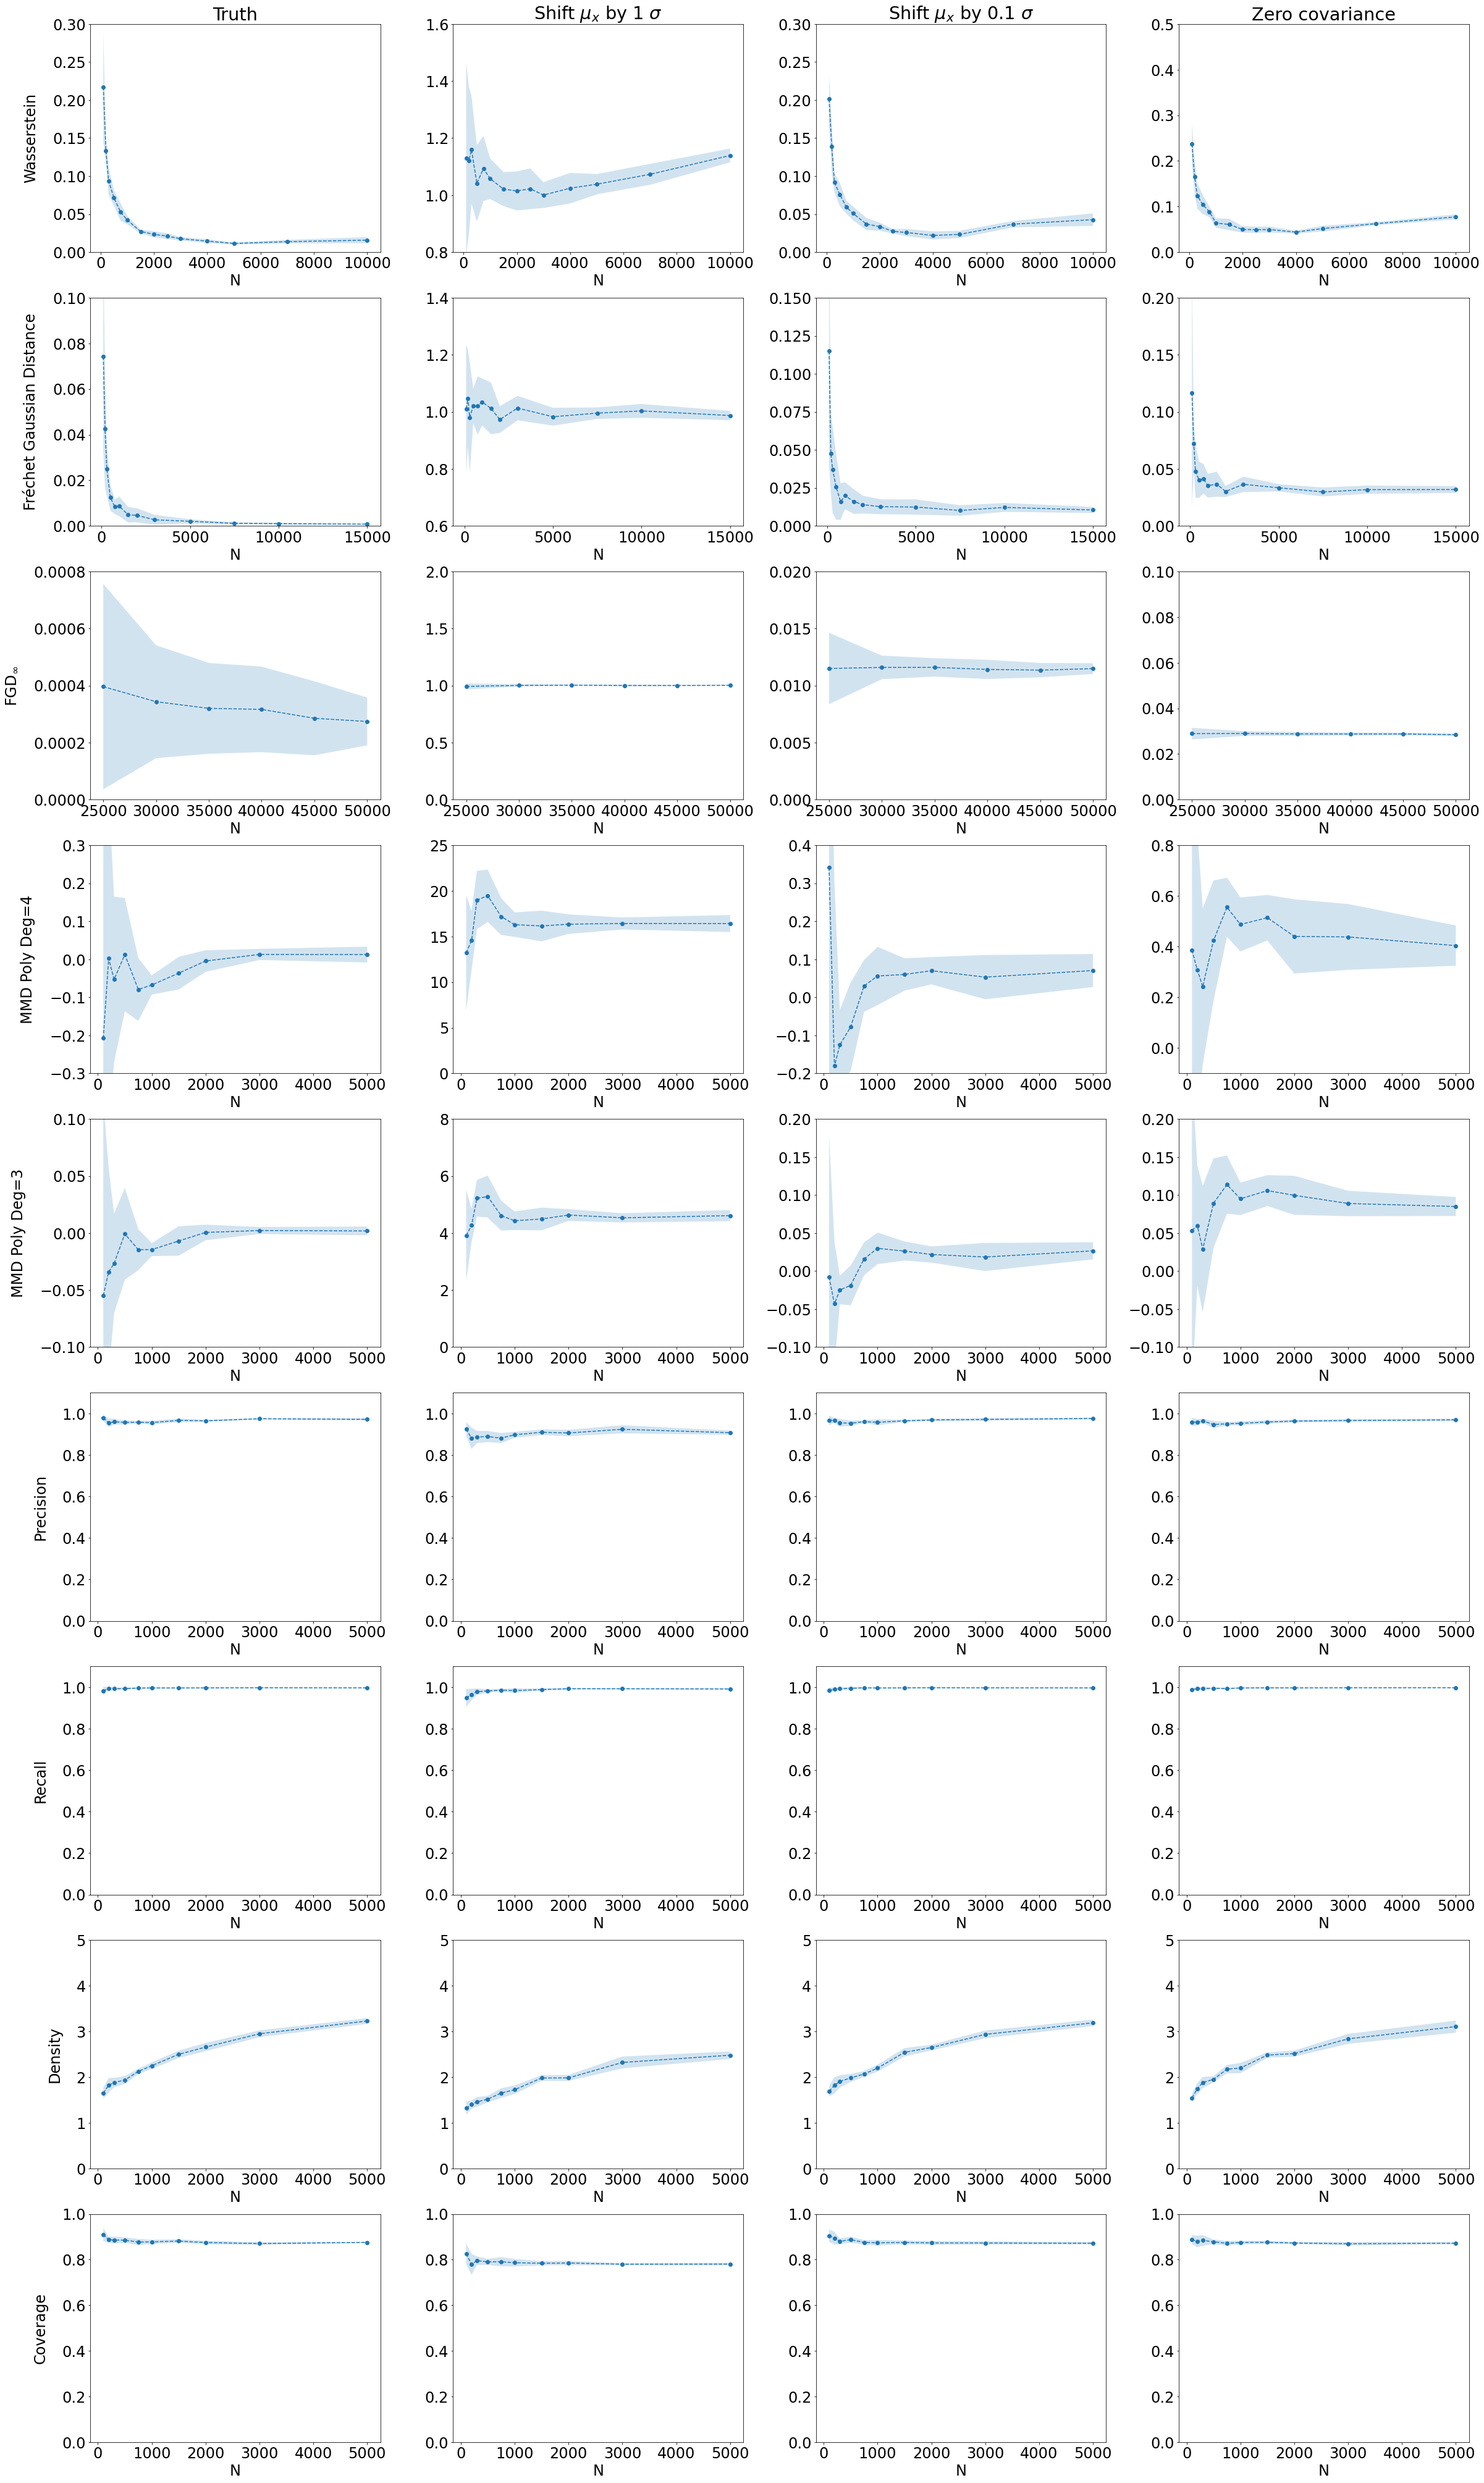

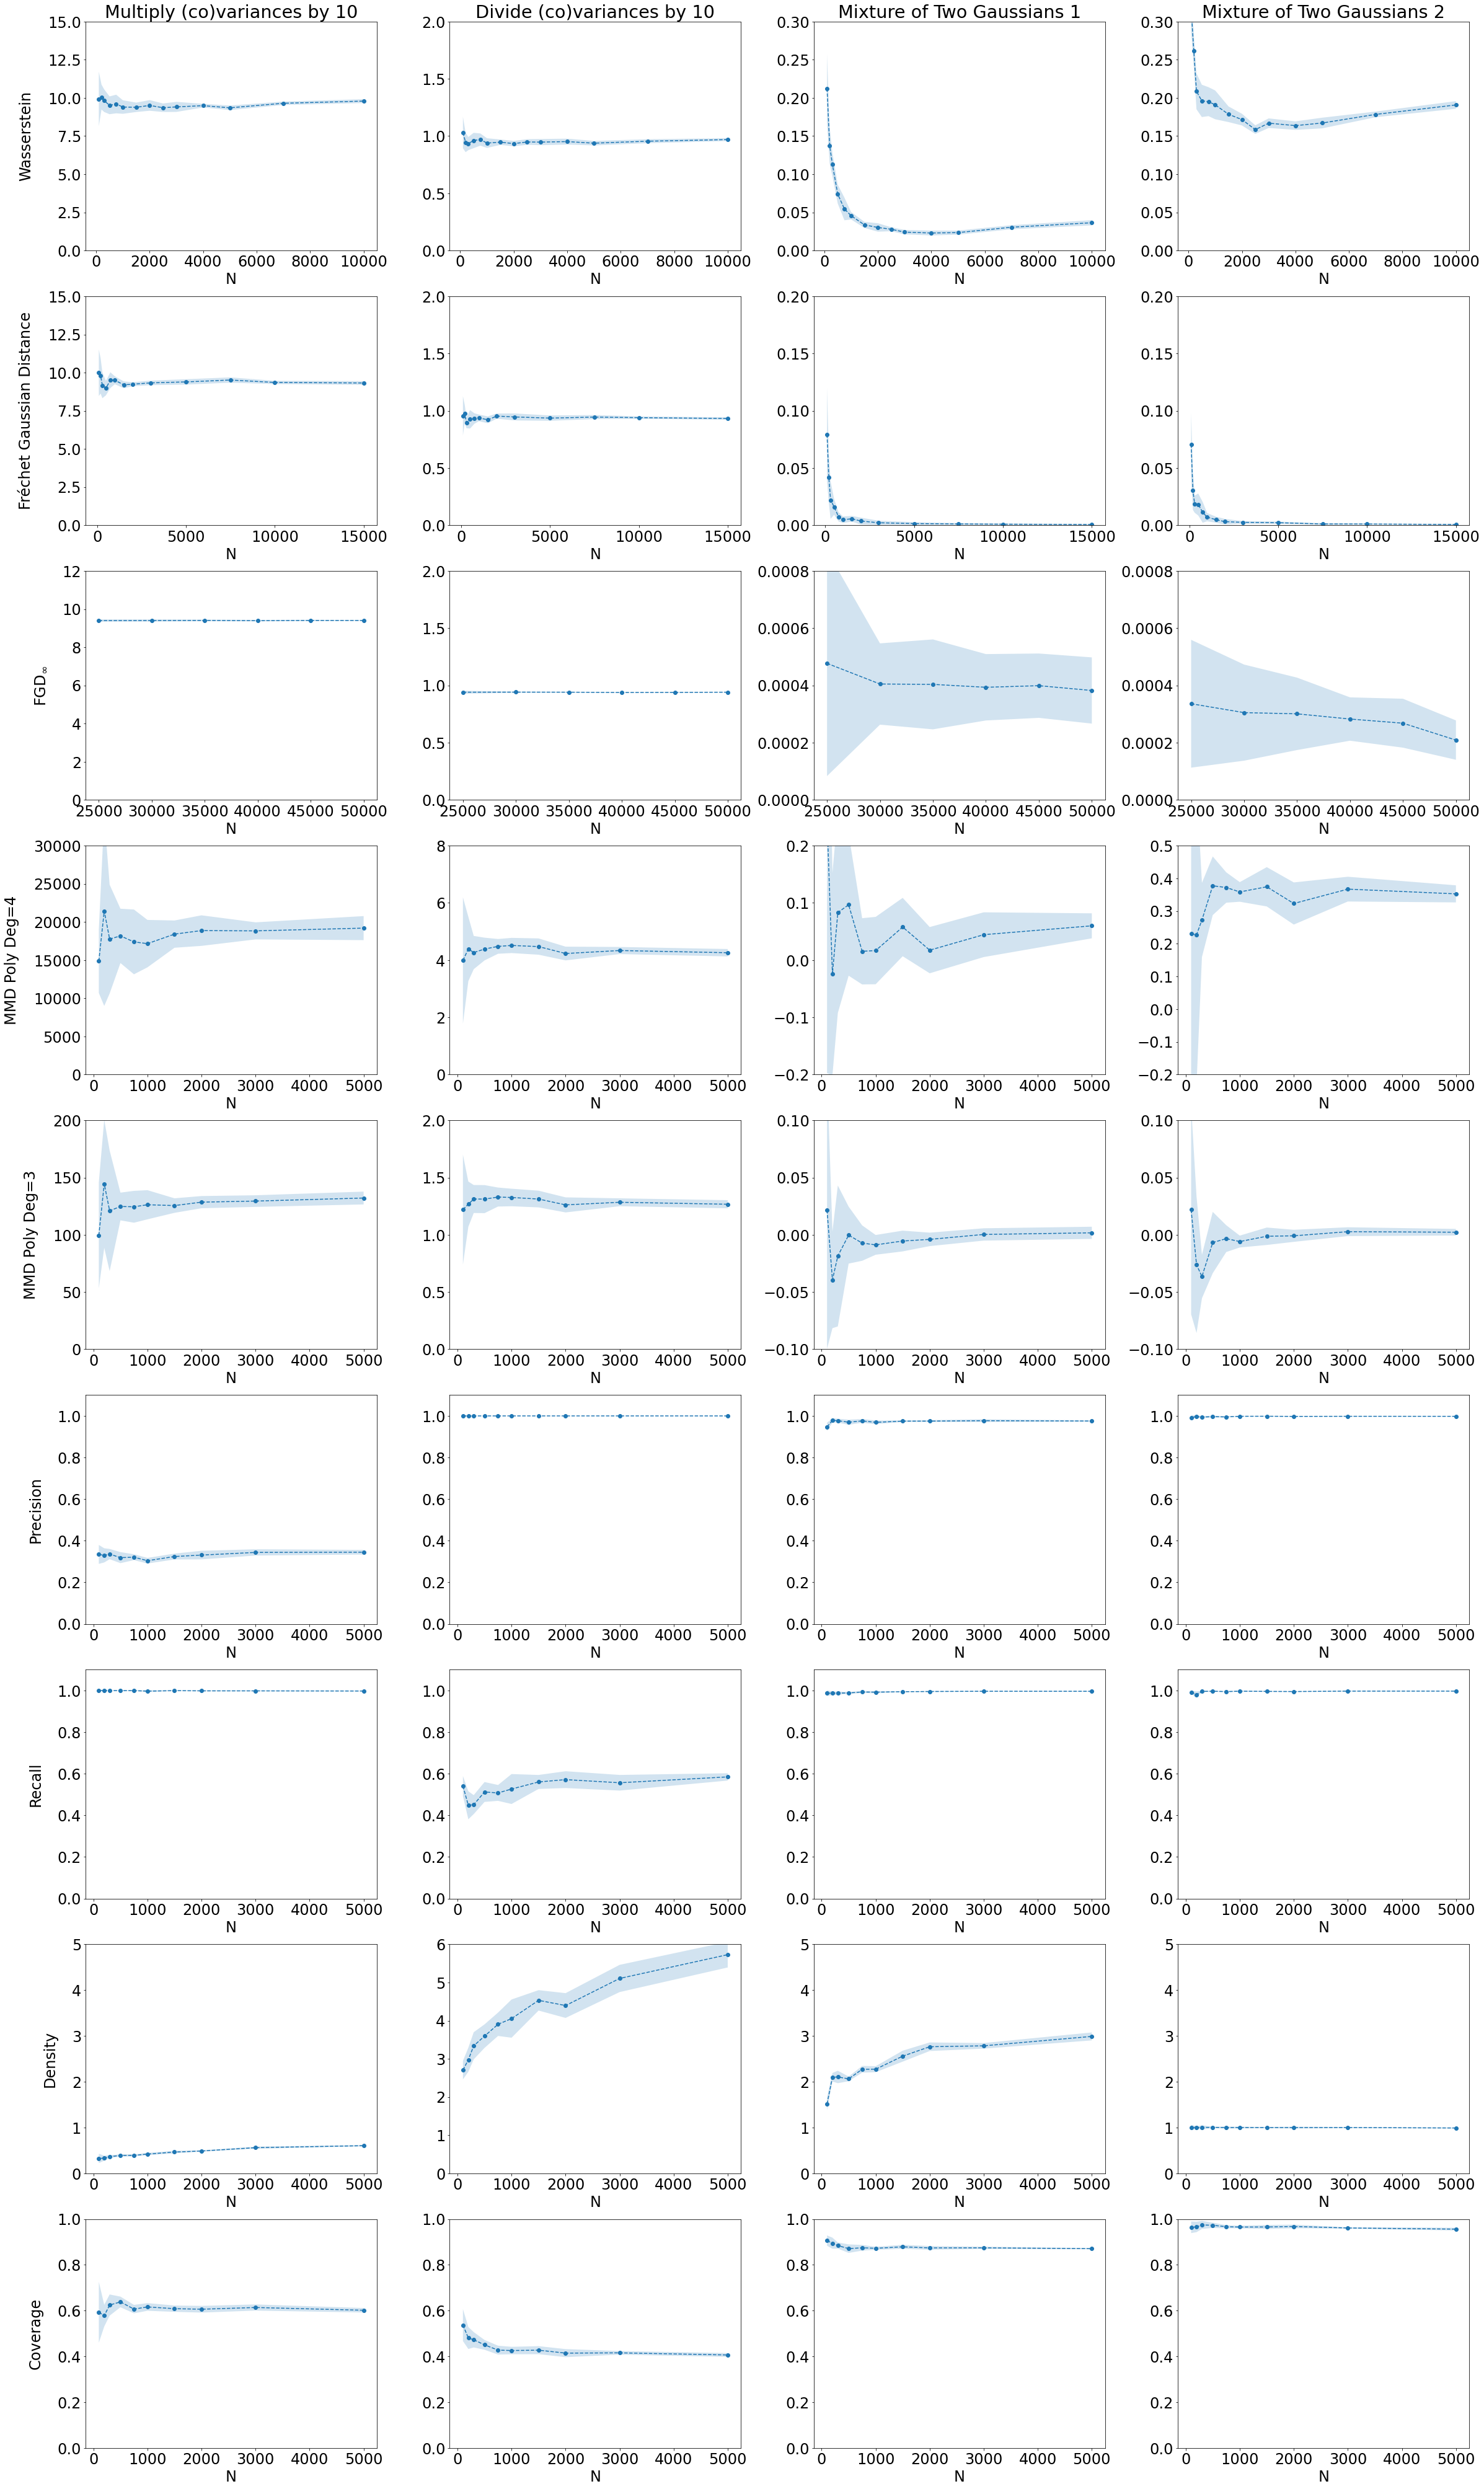

In [34]:
plt.rcParams.update({"font.size": 24})

ylims = OrderedDict(
    [
        (
            "wasserstein",
            ([0, 0.3], [0.8, 1.6], [0, 0.3], [0, 0.5], [0, 15], [0, 2], [0, 0.3], [0, 0.3]),
        ),
        ("fgd", ([0, 0.1], [0.6, 1.4], [0, 0.15], [0, 0.2], [0, 15], [0, 2], [0, 0.2], [0, 0.2])),
        (
            "fgd_inf",
            (
                [0, 8e-4],
                [0, 2],
                [0, 0.02],
                [0, 0.1],
                [0, 12],
                [0, 2],
                [0, 8e-4],
                [0, 8e-4],
            ),
        ),
        (
            "mmdup4",
            (
                [-0.3, 0.3],
                [0, 25],
                [-0.2, 0.4],
                [-0.1, 0.8],
                [0, 30000],
                [0, 8],
                [-0.2, 0.2],
                [-0.2, 0.5],
            ),
        ),
        # ("mmdub", ([0, 0.02], [0, 0.2], [0, 0.02], [0, 1], [0, 0.2], [-0.1, 0.1])),
        # (
        #     "mmdu",
        #     (
        #         [-0.01, 0.01],
        #         [0, 0.2],
        #         [-0.01, 0.01],
        #         [-0.01, 0.03],
        #         [0, 0.4],
        #         [0, 0.4],
        #         [-0.1, 0.1],
        #         [-0.1, 0.1],
        #     ),
        # ),
        # (
        #     "mmdl",
        #     (
        #         [-0.1, 0.1],
        #         [-0.2, 0.2],
        #         [-0.2, 0.2],
        #         [-0.2, 0.2],
        #         [0, 1],
        #         [0, 0.3],
        #         [-0.2, 0.2],
        #         [-0.2, 0.2],
        #     ),
        # ),
        (
            "mmdup",
            (
                [-0.1, 0.1],
                [0, 8],
                [-0.1, 0.2],
                [-0.1, 0.2],
                [0, 200],
                [0, 2],
                [-0.1, 0.1],
                [-0.1, 0.1],
            ),
        ),
        # ("mmdlp", ([-1, 1], [0, 8], [-1, 1], [-1, 1], [-100, 300], [0, 2], [-1, 1], [-1, 1])),
        # (
        #     "mmdlp4",
        #     ([-2, 2], [0, 25], [-2, 2], [-2, 2], [-10000, 30000], [0, 8], [-10, 10], [-10, 10]),
        # ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        ("density", ([0, 5], [0, 5], [0, 5], [0, 5], [0, 5], [0, 6], [0, 5], [0, 5])),
        ("coverage", ([0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1])),
    ]
)

for ploti in range(2):
    fig, axes = plt.subplots(
        nrows=len(ylims),
        ncols=int(len(test_dists) / 2),
        figsize=(len(test_dists) * 5, len(ylims) * 8),
        gridspec_kw={"wspace": 0.25},
    )

    for (mkey, (metric, metric_args, label)) in metrics.items():
        if mkey in ["dc", "pr"]:
            continue

        if mkey not in ylims:
            continue

        i = list(ylims.keys()).index(mkey)

        plotting.metric_label(axes[i][0], label)
        for l, (dkey, _) in enumerate(test_dists):
            if l // 4 != ploti:
                continue

            j = l - ploti * 4

            if i == 0:
                axes[i][j].set_title(dkey)

            plotting.plot_means_stds(
                axes[i][j],
                measurements[dkey][mkey]["mean_std"][: len(batch_sizes[mkey])],
                batch_sizes[mkey],
                ylims[mkey][l],
            )

    for k, key in enumerate(["precision", "recall"]):
        i = len(ylims) - 4 + k
        mkey = "pr"

        plotting.metric_label(axes[i][0], metrics[mkey][2][k])

        for l, (dkey, _) in enumerate(test_dists):
            if l // 4 != ploti:
                continue

            j = l - ploti * 4

            plotting.plot_means_stds(
                axes[i][j],
                measurements[dkey][mkey]["mean_std"][:, :, k],
                batch_sizes[mkey],
                ylims[key][l],
            )

    for k, key in enumerate(["density", "coverage"]):
        i = len(ylims) - 2 + k
        mkey = "dc"

        plotting.metric_label(axes[i][0], metrics[mkey][2][k])
        for l, (dkey, _) in enumerate(test_dists):
            if l // 4 != ploti:
                continue

            j = l - ploti * 4

            plotting.plot_means_stds(
                axes[i][j],
                measurements[dkey][mkey]["mean_std"][:, :, k],
                batch_sizes[mkey],
                ylims[key][l],
            )

    plt.savefig(f"{plot_dir}/toy_scores_{ploti+1}.pdf", bbox_inches="tight")


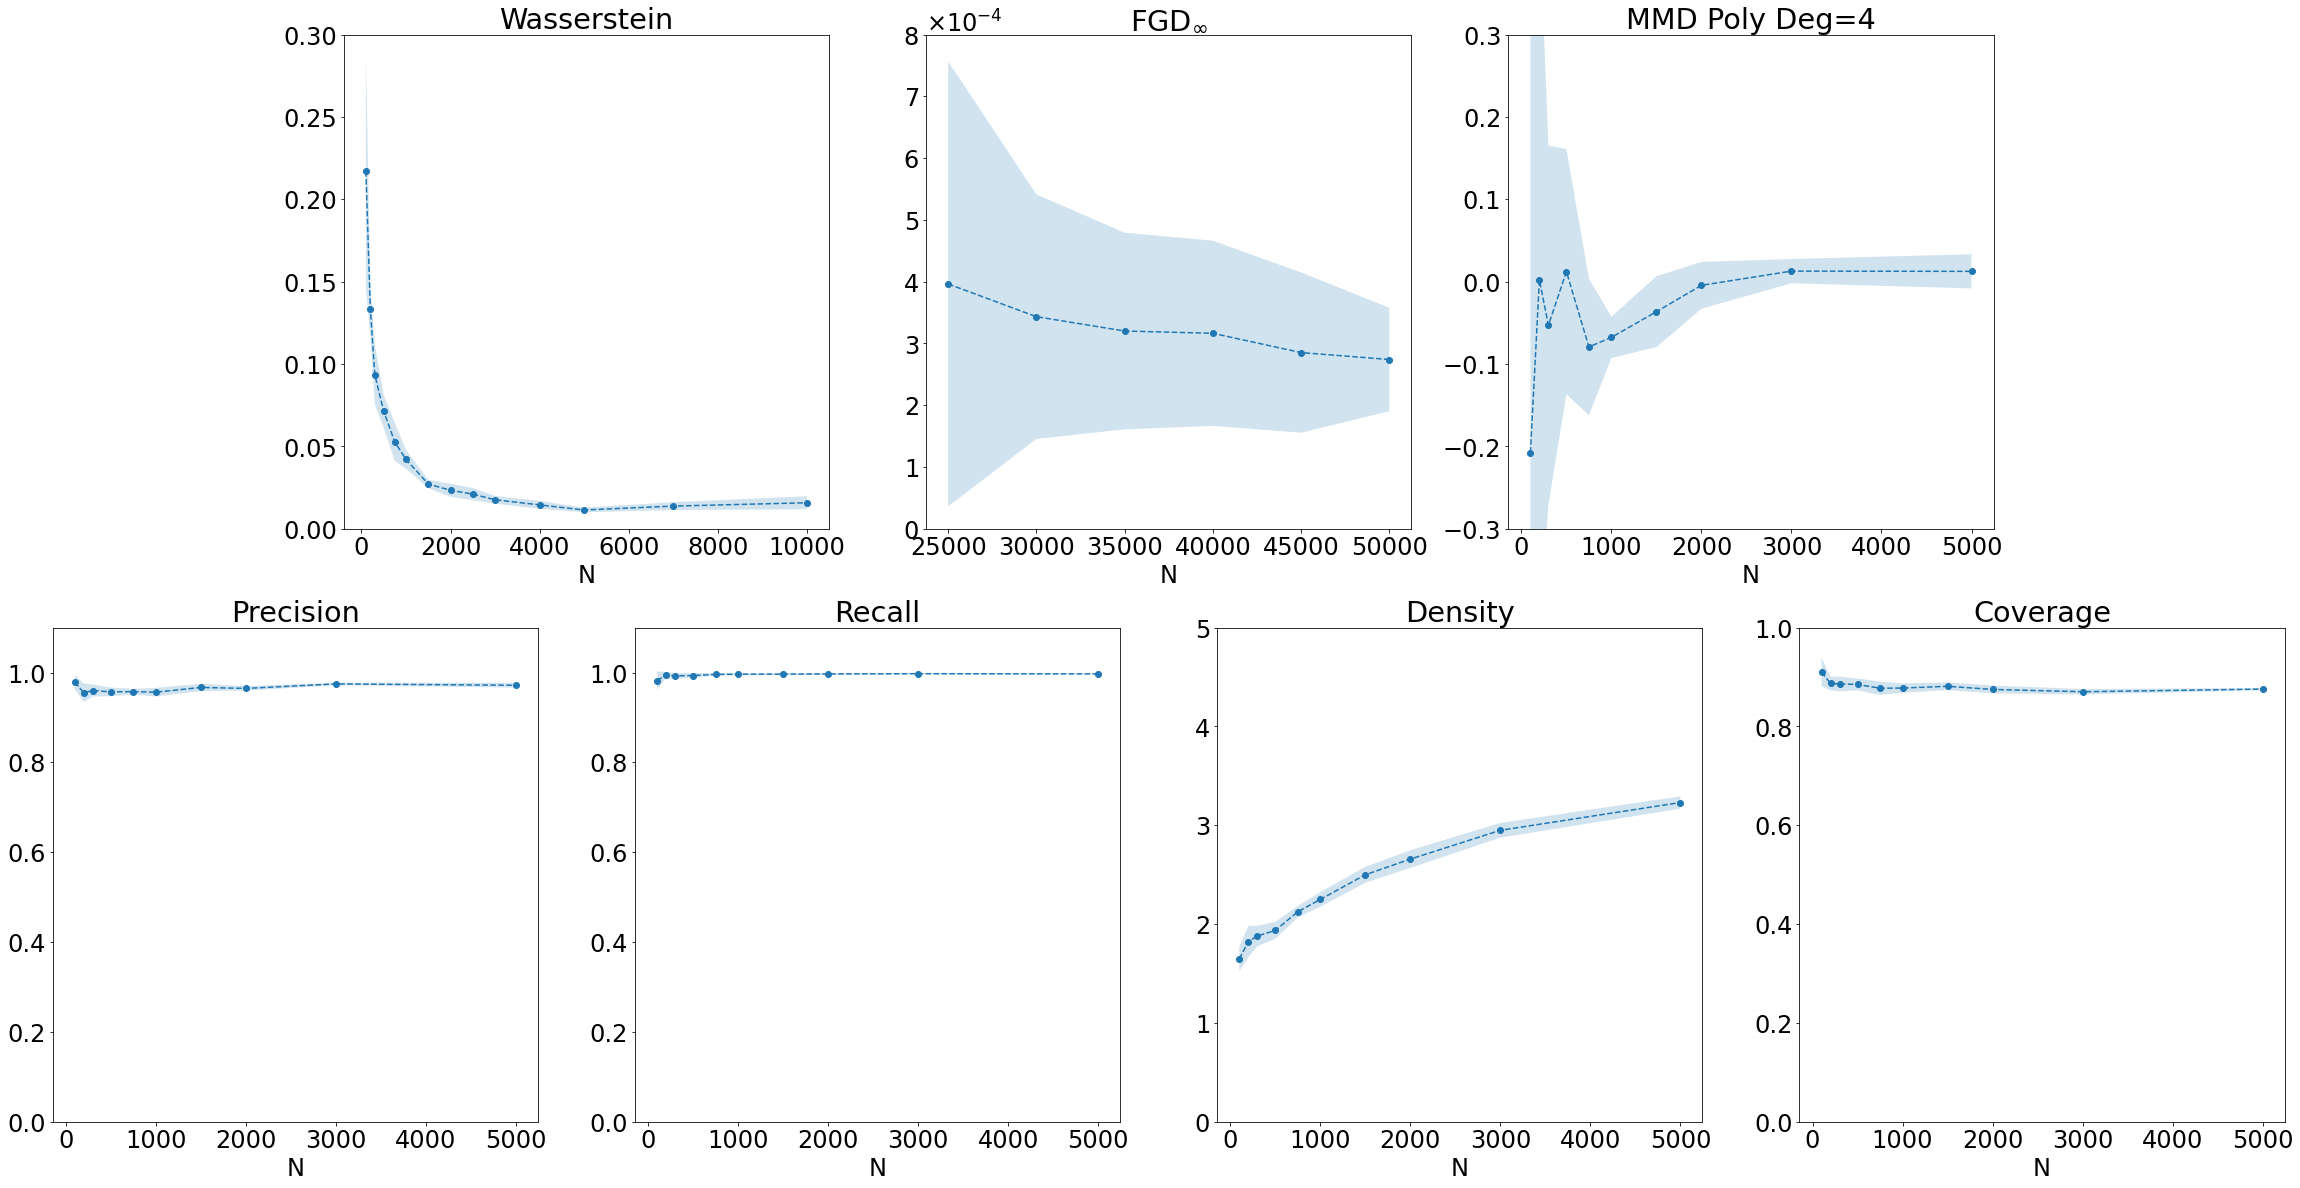

In [35]:
import matplotlib.gridspec as gridspec

plot_metrics = ['wasserstein', 'fgd_inf', 'mmdup4', 'precision', 'recall', 'density', 'coverage']

plt.figure(figsize=(40, 20))
gs = gridspec.GridSpec(2, 8)
gs.update(wspace=0.5)

plt.rcParams.update({"font.size": 24})

dkey = 'Truth'

for i, mkey in enumerate(plot_metrics):
    if i < 3:
        ax = plt.subplot(gs[0,  i * 2 + 1:i * 2 + 3])

        plotting.plot_means_stds(
            ax,
            measurements[dkey][mkey]["mean_std"][: len(batch_sizes[mkey])],
            batch_sizes[mkey],
            ylims[mkey][0],
        )
        ax.set_title(metrics[mkey][2])
        if mkey == "fgd_inf":
            # ax.set_yscale('log')
            ax.ticklabel_format(axis="y", scilimits=(0, 0), useMathText=True)
    else:
        ax = plt.subplot(gs[1, (i - 3) * 2: (i - 3) * 2 + 2])
        ylim = ylims[mkey][0]

        match mkey:
            case "precision":
                mkey = "pr"
                k = 0
            case "recall":
                mkey = "pr"
                k = 1
            case "density":
                mkey = "dc"
                k = 0
            case "coverage":
                mkey = "dc"
                k = 1

        plotting.plot_means_stds(
            ax,
            measurements[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylim,
        )
    
        ax.set_title(metrics[mkey][2][k])

plt.savefig(f"{plot_dir}/truth_scores.pdf", bbox_inches="tight")
    

# Table of values

In [30]:
def format_mean_std(mean_stds: np.ndarray):
    mean, sd = mean_stds

    if sd == 0:
        return f"${mean:.1f} \\pm 0.0$"

    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10**decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}\mathrm{{k}} \\pm {sd:.{decimals}f}\mathrm{{k}}$"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"


In [31]:
def print_mean_std(mean_stds: np.ndarray, mult: float = 1):
    return f"{mean_stds[0] * mult:.3f} ± {mean_stds[1] * mult:.3f}"


rows = []
sigs = []

for mkey, (metric, metric_args, label) in metrics.items():
    if (mkey.startswith("mmd") and mkey != "mmdup4") or mkey == "fgd":
        continue
    if mkey == "fgd":
        continue

    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l]
            sig = []

            true_mean, true_std = measurements["Truth"][mkey]["mean_std"][-1, :, i]
            for dkey, values in measurements.items():
                row.append(
                    format_mean_std(values[mkey]["mean_std"][: len(batch_sizes[mkey])][-1, :, i])
                )
                sig.append((values[mkey]["mean_std"][-1, 0, i] - true_mean) / true_std)

            rows.append(row)
            sigs.append(sig)

    else:
        sig = []
        true_mean, true_std = measurements["Truth"][mkey]["mean_std"][-1]

        if mkey in ["fgd_inf", "mmdu"]:
            row = [f"{label} $\\times 10^3$"]

            for dkey, values in measurements.items():
                row.append(
                    format_mean_std(values[mkey]["mean_std"][: len(batch_sizes[mkey])][-1, :] * 1e3)
                )
                sig.append((values[mkey]["mean_std"][-1, 0] - true_mean) / true_std)
        else:
            row = [label]

            for dkey, values in measurements.items():
                row.append(
                    format_mean_std(values[mkey]["mean_std"][: len(batch_sizes[mkey])][-1, :])
                )
                sig.append((values[mkey]["mean_std"][-1, 0] - true_mean) / true_std)

        rows.append(row)
        sigs.append(sig)

sigs = np.array(sigs)
max_sigs = np.argmax(sigs, axis=0)

for i, midx in enumerate(max_sigs[1:]):
    rows[midx][i + 2] = r"$\mathbf{" + rows[midx][i + 2][1:-1] + r"}$"

# textable = [" & ".join([rf"\multirow{{3}}{{*}}{{{s}}}" for s in ["Metric"] + list(measurements.keys())]) + "\\\\\n"] + [
#     " & ".join(row) + "\\\\\n" for row in rows
# ]

textable = [
    " & ".join([rf"\multirow{{3}}{{*}}{{{s}}}" for s in ["Metric"] + list(measurements.keys())])
    + "\\\\\n"
] + [" & ".join([rf"\multirow{{2}}{{*}}{{{s}}}" for s in row]) + "\\\\\n" for row in rows]


with open(f"{plot_dir}/measurements.tex", "w") as f:
    f.writelines(textable)

results = pd.DataFrame(rows, columns=["Metric"] + list(measurements.keys()))

display(Markdown(results.to_markdown()))


|    | Metric                              | Truth             | Shift $\mu_x$ by 1 $\sigma$   | Shift $\mu_x$ by 0.1 $\sigma$   | Zero covariance         | Multiply (co)variances by 10            | Divide (co)variances by 10   | Mixture of Two Gaussians 1   | Mixture of Two Gaussians 2   |
|---:|:------------------------------------|:------------------|:------------------------------|:--------------------------------|:------------------------|:----------------------------------------|:-----------------------------|:-----------------------------|:-----------------------------|
|  0 | Wasserstein                         | $0.016 \pm 0.004$ | $1.14 \pm 0.02$               | $0.043 \pm 0.008$               | $0.077 \pm 0.006$       | $9.8 \pm 0.1$                           | $0.97 \pm 0.01$              | $\mathbf{0.036 \pm 0.003}$   | $\mathbf{0.191 \pm 0.005}$   |
|  1 | $\mathrm{FGD}_\infty$ $\times 10^3$ | $0.27 \pm 0.08$   | $\mathbf{1002 \pm 4}$         | $\mathbf{11.5 \pm 0.5}$         | $\mathbf{28.4 \pm 0.5}$ | $9400 \pm 20$                           | $\mathbf{941 \pm 2}$         | $0.4 \pm 0.1$                | $0.21 \pm 0.07$              |
|  2 | MMD Poly Deg=4                      | $0.01 \pm 0.02$   | $16.4 \pm 0.9$                | $0.07 \pm 0.04$                 | $0.40 \pm 0.08$         | $\mathbf{19\mathrm{k} \pm 1\mathrm{k}}$ | $4.3 \pm 0.1$                | $0.06 \pm 0.02$              | $0.35 \pm 0.03$              |
|  3 | Precision                           | $0.972 \pm 0.005$ | $0.91 \pm 0.01$               | $0.976 \pm 0.004$               | $0.969 \pm 0.006$       | $0.34 \pm 0.01$                         | $1.0 \pm 0.0$                | $0.975 \pm 0.003$            | $0.9976 \pm 0.0007$          |
|  4 | Recall                              | $0.997 \pm 0.001$ | $0.992 \pm 0.003$             | $0.997 \pm 0.001$               | $0.9976 \pm 0.0006$     | $0.998 \pm 0.001$                       | $0.58 \pm 0.02$              | $0.996 \pm 0.001$            | $0.9970 \pm 0.0009$          |
|  5 | Density                             | $3.23 \pm 0.06$   | $2.48 \pm 0.08$               | $3.19 \pm 0.07$                 | $3.1 \pm 0.1$           | $0.60 \pm 0.02$                         | $5.7 \pm 0.3$                | $2.99 \pm 0.09$              | $0.989 \pm 0.009$            |
|  6 | Coverage                            | $0.876 \pm 0.002$ | $0.780 \pm 0.006$             | $0.872 \pm 0.005$               | $0.872 \pm 0.004$       | $0.60 \pm 0.01$                         | $0.406 \pm 0.008$            | $0.871 \pm 0.002$            | $0.956 \pm 0.006$            |

In [39]:
results.to_csv(f"{plot_dir}/scores.csv")


# Plot Timings

In [111]:
timings = OrderedDict()

for mkey in metrics:
    mtimings = []
    for i, batch_size in enumerate(batch_sizes[mkey]):
        mbtimings = []
        for values in measurements.values():
            mbtimings.append(values[mkey]["timing"][i])

        mtimings.append([np.mean(mbtimings), np.std(mbtimings)])

    timings[mkey] = np.array(mtimings)


In [ ]:
plt.rcParams.update({"font.size": 16})

nrows = 2
ncols = int(ceil(len(metrics) / nrows))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 10, nrows * 8),
    gridspec_kw={"wspace": 0.25},
)

for i, (mkey, (metric, metric_args, label)) in enumerate(metrics.items()):
    row = i // ncols
    col = i % ncols

    if isinstance(label, list):
        label = " & ".join(label)

    means = timings[mkey][:, 0][: len(batch_sizes[mkey])]
    stds = timings[mkey][:, 1][: len(batch_sizes[mkey])]

    axes[row][col].plot(
        batch_sizes[mkey][: len(means)],
        means,
        marker="o",
        linestyle="--",
    )

    axes[row][col].fill_between(
        batch_sizes[mkey][: len(means)], means - stds, means + stds, alpha=0.2
    )
    axes[row][col].set_title(label)
    axes[row][col].set_xlabel("N")
    axes[row][col].set_ylabel("Time (s)")

plt.savefig(f"{plot_dir}/timings.pdf", bbox_inches="tight")
